# MP5: Training Your Diffusion Model!

## Setup environment

In [1]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
import torch # added
from torch import optim # added
from torch import nn
from torch import cat
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import numpy as np

## Visualization helper function

In [2]:
def visualize_images_with_titles(images: torch.Tensor, column_names: list[str]):
    """
    Visualize images as a grid and title the columns with the provided names.

    Args:
        images: (N, C, H, W) tensor of images, where N is (number of rows * number of columns)
        column_names: List of column names for the titles.

    Example usage:
    visualize_images_with_titles(torch.randn(16, 1, 32, 32), ['1', '2', '3', '4'])
    """
    num_images, num_columns = images.shape[0], len(column_names)
    assert num_images % num_columns == 0, 'Number of images must be a multiple of the number of columns.'

    num_rows = num_images // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 1, num_rows * 1))

    for i, ax in enumerate(axes.flat):
        img = images[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        if i < num_columns:
            ax.set_title(column_names[i % num_columns])

    plt.tight_layout()
    plt.show()


# Part 1: Training a Single-step Denoising UNet


## Implementing Simple and Composed Ops

In [3]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.process = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.process(x)


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.process = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.process(x)


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.process = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.process(x)


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.process = nn.Sequential(
            nn.AvgPool2d(kernel_size=7),
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.process(x)


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.process = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=7, stride=7, padding=0),
            nn.BatchNorm2d(in_channels),
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.process(x)


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.process = nn.Sequential(
            Conv(in_channels, out_channels),
            Conv(out_channels, out_channels),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.process(x)


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.process = nn.Sequential(
            DownConv(in_channels, out_channels),
            ConvBlock(out_channels, out_channels),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.process(x)


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.process = nn.Sequential(
            UpConv(in_channels, out_channels),
            ConvBlock(out_channels, out_channels),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.process(x)

## Implementing Unconditional UNet

In [4]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.convblock1 = ConvBlock(in_channels, num_hiddens)
        self.downblock1 = DownBlock(num_hiddens, num_hiddens)
        self.downblock2 = DownBlock(num_hiddens, num_hiddens * 2)
        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2)
        self.upblock1 = UpBlock(num_hiddens * 4, num_hiddens)
        self.upblock2 = UpBlock(num_hiddens * 2, num_hiddens)
        self.convblock2 = ConvBlock(num_hiddens * 2, num_hiddens)
        self.conv2d = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        x1 = self.convblock1(x)
        x2 = self.downblock1(x1)
        x3 = self.downblock2(x2)
        x4 = self.flatten(x3)
        x5 = self.unflatten(x4)
        x6 = torch.cat([x3, x5], dim=1)
        x7 = self.upblock1(x6)
        x8 = torch.cat([x2, x7], dim=1)
        x9 = self.upblock2(x8)
        x10 = torch.cat([x1, x9], dim=1)
        x11 = self.convblock2(x10)
        x12 = self.conv2d(x11)
        assert x12.shape[-2:] == (28, 28), "Expect output shape to be (28, 28)."
        return x12

## Visualizing the noising process

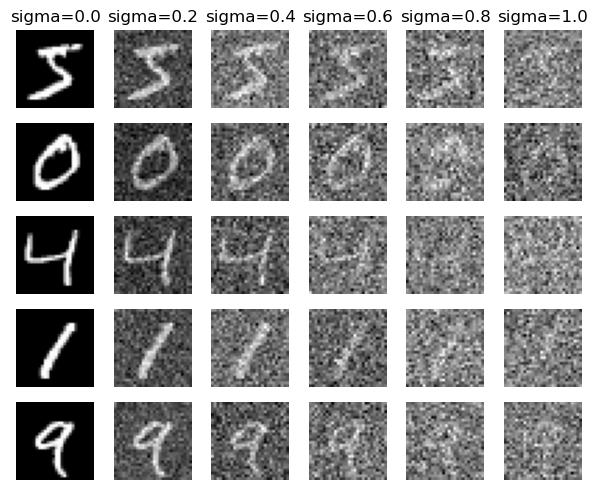

In [5]:
dataset = MNIST(root="data", download=True, transform=ToTensor(), train=True)

# TODO
sigmas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
images = torch.stack([dataset[i][0] for i in range(5)], dim = 0)
noisy_images = []
for image in images:
    for sigma in sigmas:
        noise = torch.randn_like(image) * sigma
        noisy_image = image + noise
        noisy_images.append(noisy_image)
noisy_images = torch.stack(noisy_images, dim=0)
visualize_images_with_titles(noisy_images, ['sigma=0.0', 'sigma=0.2', 'sigma=0.4', 'sigma=0.6', 'sigma=0.8', 'sigma=1.0'])
plt.show()

## Training a Single-Step Unconditional UNet

- Plot the loss curve
- Sample results on the test set

cuda
Epoch [1/5], Batch [1/235], Loss: 0.2436
Epoch [1/5], Batch [101/235], Loss: 0.0147
Epoch [1/5], Batch [201/235], Loss: 0.0121


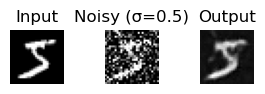

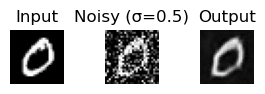

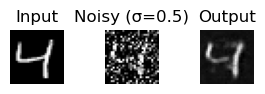

Epoch [1/5], Loss: 0.0122
Epoch [2/5], Batch [1/235], Loss: 0.0121
Epoch [2/5], Batch [101/235], Loss: 0.0109
Epoch [2/5], Batch [201/235], Loss: 0.0103
Epoch [2/5], Loss: 0.0098
Epoch [3/5], Batch [1/235], Loss: 0.0100
Epoch [3/5], Batch [101/235], Loss: 0.0094
Epoch [3/5], Batch [201/235], Loss: 0.0092
Epoch [3/5], Loss: 0.0090
Epoch [4/5], Batch [1/235], Loss: 0.0090
Epoch [4/5], Batch [101/235], Loss: 0.0087
Epoch [4/5], Batch [201/235], Loss: 0.0083
Epoch [4/5], Loss: 0.0097
Epoch [5/5], Batch [1/235], Loss: 0.0082
Epoch [5/5], Batch [101/235], Loss: 0.0086
Epoch [5/5], Batch [201/235], Loss: 0.0083


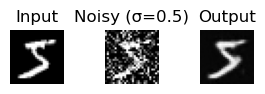

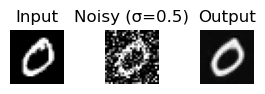

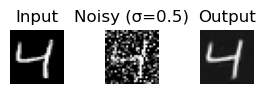

Epoch [5/5], Loss: 0.0080


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

sigma = 0.5
batch_size = 256
D = 128
epochs = 5
learning_rate = 1e-4

dataset = MNIST(root='data', download=True, transform=ToTensor(), train=True)
test_dataset = MNIST(root='data', download=True, transform=ToTensor(), train=False)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=True)

model = UnconditionalUNet(in_channels=1, num_hiddens=D).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

losses = []
step = []
for epoch in range(epochs):
    model.train()
    for i, (images, _) in enumerate(dataloader):

        images = images.to(device)
        noise = torch.randn_like(images) * sigma
        noisy_images = images + noise
        optimizer.zero_grad()
        outputs = model(noisy_images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        step.append(epoch * len(dataloader) + i)
        if i%100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

    if epoch == 0 or epoch == 4:
        model.eval()
        images = torch.stack([dataset[i][0] for i in range(3)], dim=0).to(device)
        noisy_samples = []
        outputs = []
        for img in images:
            noise = torch.randn_like(img) * sigma
            noisy_image = torch.clamp(img + noise, 0, 1)
            noisy_samples.append(noisy_image)
            outputs.append(model(noisy_image.unsqueeze(0)))
        noisy_samples = torch.stack(noisy_samples, dim=0)
        for i in range(3):
            visualize_images_with_titles(torch.stack([images[i].detach(), noisy_samples[i].detach(), outputs[i][0].detach()]), ["Input", "Noisy (σ=0.5)", "Output"])

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


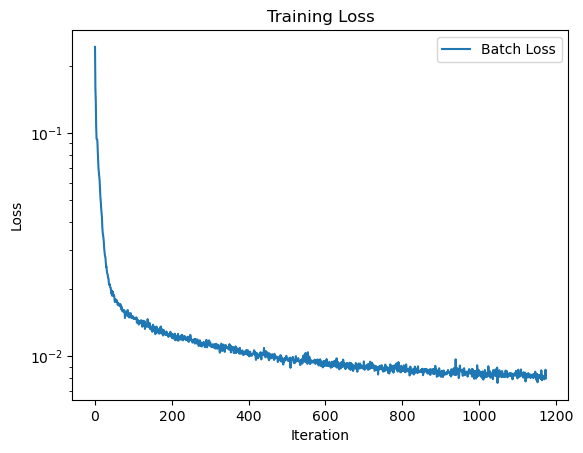

In [10]:
plt.plot(losses, label='Batch Loss')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.yscale('log')

plt.legend()
plt.show()

## Out-of-Distribution Testing

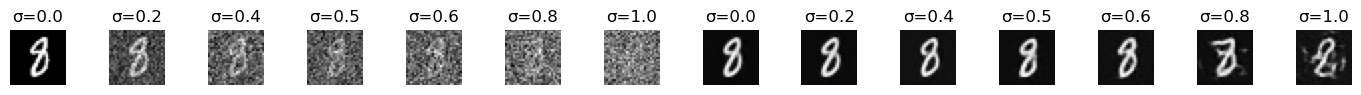

In [11]:
# TODO
sigmas = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
example_image = test_dataset[np.random.choice(len(test_dataset), size=1, replace=False)[0]][0].unsqueeze(0).to(device)

noisy_images = []
denoised_images = []

for sigma in sigmas:
    noise = torch.randn_like(example_image) * sigma
    noisy_image = example_image + noise
    noisy_images.append(noisy_image)

    denoised_image = model(noisy_image)
    denoised_images.append(denoised_image)

titles = [f"σ={sigma:.1f}" for sigma in sigmas]
images_to_visualize = torch.cat(noisy_images + denoised_images, dim=0)
visualize_images_with_titles(images_to_visualize.detach(), titles * 2)

# Part 2: Training a Diffusion Model

## Implementing a Time-conditioned UNet

In [12]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.process = nn.Sequential(
            nn.Linear(in_channels, out_channels),
            nn.GELU(),
            nn.Linear(out_channels, out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.process(x)


class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.convblock1 = ConvBlock(in_channels, num_hiddens)
        self.downblock1 = DownBlock(num_hiddens, num_hiddens)
        self.downblock2 = DownBlock(num_hiddens, num_hiddens * 2)
        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2)
        self.upblock1 = UpBlock(num_hiddens * 4, num_hiddens)
        self.upblock2 = UpBlock(num_hiddens * 2, num_hiddens)
        self.convblock2 = ConvBlock(num_hiddens * 2, num_hiddens)
        self.conv2d = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, stride=1, padding=1)
        self.fc1_t = FCBlock(1, num_hiddens * 2)
        self.fc2_t = FCBlock(1, num_hiddens)

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        if t.dtype != torch.float32:
            t = t.float()
        t = t.view(-1, 1)
        x1 = self.convblock1(x)
        x2 = self.downblock1(x1)
        x3 = self.downblock2(x2)
        x4 = self.flatten(x3)
        x5 = self.unflatten(x4) + self.fc1_t(t).view(-1, self.num_hiddens * 2, 1, 1)
        x7 = torch.cat([x3, x5], dim=1)
        x8 = self.upblock1(x7) + self.fc2_t(t).view(-1, self.num_hiddens, 1, 1)
        x10 = torch.cat([x2, x8], dim=1)
        x11 = self.upblock2(x10)
        x12 = torch.cat([x1, x11], dim=1)
        x13 = self.convblock2(x12)
        x14 = self.conv2d(x13)
        return x14

## Implementing DDPM Forward and Inverse Process for Time-conditioned Denoising

In [6]:
def ddpm_schedule(beta1: float, beta2: float, num_ts: int) -> dict:
    """Constants for DDPM training and sampling.

    Arguments:
        beta1: float, starting beta value.
        beta2: float, ending beta value.
        num_ts: int, number of timesteps.

    Returns:
        dict with keys:
            betas: linear schedule of betas from beta1 to beta2.
            alphas: 1 - betas.
            alpha_bars: cumulative product of alphas.
    """
    assert beta1 < beta2 < 1.0, "Expect beta1 < beta2 < 1.0."
    betas = torch.linspace(beta1, beta2, num_ts)
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    return  {
        "betas": betas,
        "alphas": alphas,
        "alpha_bars": alpha_bars,
    }

In [14]:
def ddpm_forward(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) diffusion loss.
    """
    unet.train()
    # YOUR CODE HERE.
    batch_size = x_0.shape[0]
    t = torch.randint(0, num_ts, (batch_size,), device=x_0.device)
    noise = torch.randn_like(x_0)
    alpha_bar_t = ddpm_schedule['alpha_bars'][t].view(-1, 1, 1, 1)
    x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise
    predicted_noise = unet(x_t, t / num_ts)
    loss = nn.functional.mse_loss(predicted_noise, noise)
    return loss

In [15]:
@torch.inference_mode()
def ddpm_sample(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    # YOUR CODE HERE.
    device = next(unet.parameters()).device
    batch_size = 20
    x_t = torch.randn((batch_size, 1, *img_wh), device=ddpm_schedule['alphas'].device)
    for t in reversed(range(num_ts)):
        t_tensor = torch.full((x_t.shape[0],), t / num_ts, device=device).float()
        eps_theta = unet(x_t, t_tensor)

        alpha_t = ddpm_schedule['alphas'][t].view(-1, 1, 1, 1)
        alpha_bar_t = ddpm_schedule['alpha_bars'][t].view(-1, 1, 1, 1)
        beta_t = ddpm_schedule['betas'][t].view(-1, 1, 1, 1)

        z = torch.randn_like(x_t) if t > 0 else torch.zeros_like(x_t)
        x_t = (1 / torch.sqrt(alpha_t)) * (x_t - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * eps_theta) + (torch.sqrt(beta_t) * z)
    return torch.clamp(x_t, 0, 1)

In [16]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.num_ts = num_ts
        self.p_uncond = p_uncond

        self.ddpm_schedule = nn.ParameterDict(ddpm_schedule(betas[0], betas[1], num_ts))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, img_wh, self.num_ts, seed
        )

## Training the Time-conditioned UNet

- Plot the loss curve
- Sample results on the test set

cuda
Epoch [1/20], Batch [1/469], Loss: 1.1284
Epoch [1/20], Batch [101/469], Loss: 0.0384
Epoch [1/20], Batch [201/469], Loss: 0.0322
Epoch [1/20], Batch [301/469], Loss: 0.0346
Epoch [1/20], Batch [401/469], Loss: 0.0369


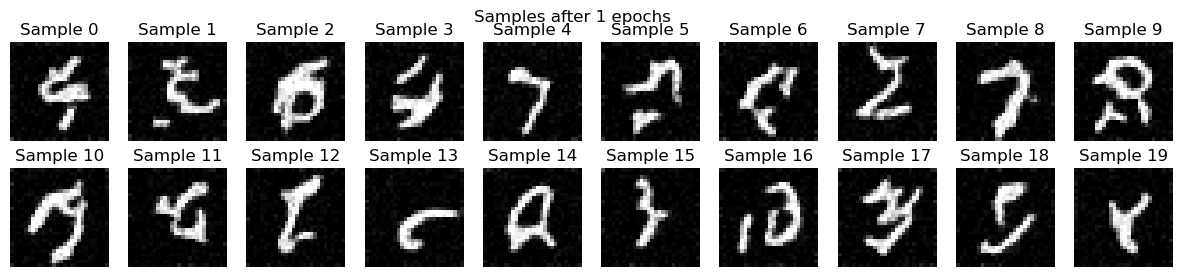

Epoch [1/20], Loss: 0.0256
Epoch [2/20], Batch [1/469], Loss: 0.0287
Epoch [2/20], Batch [101/469], Loss: 0.0317
Epoch [2/20], Batch [201/469], Loss: 0.0294
Epoch [2/20], Batch [301/469], Loss: 0.0250
Epoch [2/20], Batch [401/469], Loss: 0.0316
Epoch [2/20], Loss: 0.0309
Epoch [3/20], Batch [1/469], Loss: 0.0334
Epoch [3/20], Batch [101/469], Loss: 0.0380
Epoch [3/20], Batch [201/469], Loss: 0.0210
Epoch [3/20], Batch [301/469], Loss: 0.0179
Epoch [3/20], Batch [401/469], Loss: 0.0250
Epoch [3/20], Loss: 0.0194
Epoch [4/20], Batch [1/469], Loss: 0.0208
Epoch [4/20], Batch [101/469], Loss: 0.0201
Epoch [4/20], Batch [201/469], Loss: 0.0183
Epoch [4/20], Batch [301/469], Loss: 0.0295
Epoch [4/20], Batch [401/469], Loss: 0.0254
Epoch [4/20], Loss: 0.0414
Epoch [5/20], Batch [1/469], Loss: 0.0223
Epoch [5/20], Batch [101/469], Loss: 0.0216
Epoch [5/20], Batch [201/469], Loss: 0.0245
Epoch [5/20], Batch [301/469], Loss: 0.0128
Epoch [5/20], Batch [401/469], Loss: 0.0198


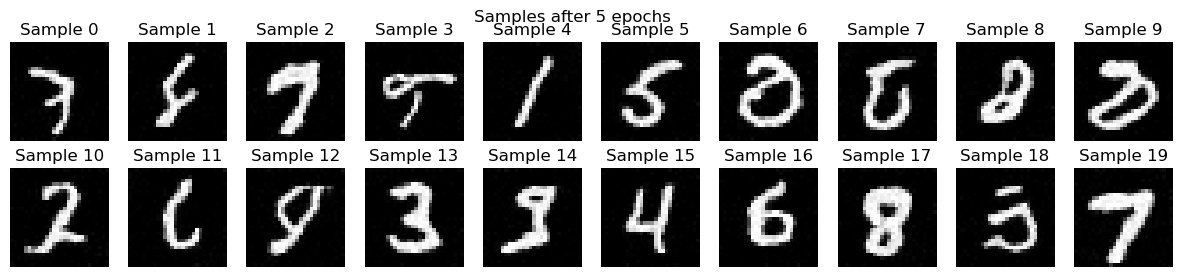

Epoch [5/20], Loss: 0.0161
Epoch [6/20], Batch [1/469], Loss: 0.0208
Epoch [6/20], Batch [101/469], Loss: 0.0194
Epoch [6/20], Batch [201/469], Loss: 0.0199
Epoch [6/20], Batch [301/469], Loss: 0.0186
Epoch [6/20], Batch [401/469], Loss: 0.0178
Epoch [6/20], Loss: 0.0180
Epoch [7/20], Batch [1/469], Loss: 0.0163
Epoch [7/20], Batch [101/469], Loss: 0.0163
Epoch [7/20], Batch [201/469], Loss: 0.0182
Epoch [7/20], Batch [301/469], Loss: 0.0225
Epoch [7/20], Batch [401/469], Loss: 0.0260
Epoch [7/20], Loss: 0.0266
Epoch [8/20], Batch [1/469], Loss: 0.0186
Epoch [8/20], Batch [101/469], Loss: 0.0228
Epoch [8/20], Batch [201/469], Loss: 0.0211
Epoch [8/20], Batch [301/469], Loss: 0.0139
Epoch [8/20], Batch [401/469], Loss: 0.0159
Epoch [8/20], Loss: 0.0150
Epoch [9/20], Batch [1/469], Loss: 0.0232
Epoch [9/20], Batch [101/469], Loss: 0.0166
Epoch [9/20], Batch [201/469], Loss: 0.0154
Epoch [9/20], Batch [301/469], Loss: 0.0202
Epoch [9/20], Batch [401/469], Loss: 0.0213
Epoch [9/20], Loss: 

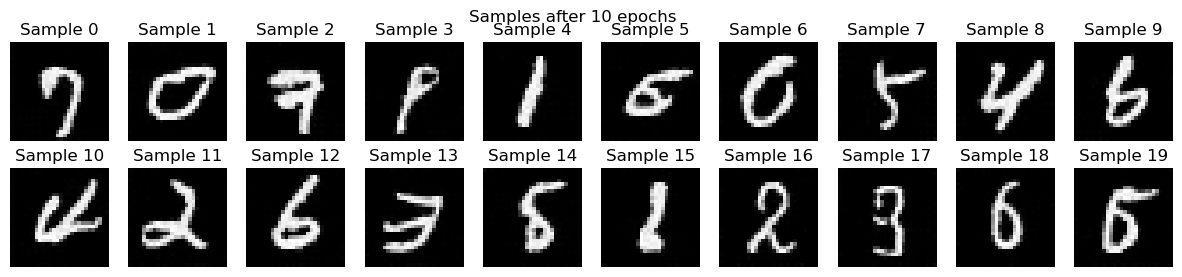

Epoch [10/20], Loss: 0.0125
Epoch [11/20], Batch [1/469], Loss: 0.0136
Epoch [11/20], Batch [101/469], Loss: 0.0143
Epoch [11/20], Batch [201/469], Loss: 0.0214
Epoch [11/20], Batch [301/469], Loss: 0.0175
Epoch [11/20], Batch [401/469], Loss: 0.0155
Epoch [11/20], Loss: 0.0189
Epoch [12/20], Batch [1/469], Loss: 0.0180
Epoch [12/20], Batch [101/469], Loss: 0.0200
Epoch [12/20], Batch [201/469], Loss: 0.0175
Epoch [12/20], Batch [301/469], Loss: 0.0210
Epoch [12/20], Batch [401/469], Loss: 0.0177
Epoch [12/20], Loss: 0.0191
Epoch [13/20], Batch [1/469], Loss: 0.0157
Epoch [13/20], Batch [101/469], Loss: 0.0162
Epoch [13/20], Batch [201/469], Loss: 0.0132
Epoch [13/20], Batch [301/469], Loss: 0.0181
Epoch [13/20], Batch [401/469], Loss: 0.0191
Epoch [13/20], Loss: 0.0219
Epoch [14/20], Batch [1/469], Loss: 0.0155
Epoch [14/20], Batch [101/469], Loss: 0.0131
Epoch [14/20], Batch [201/469], Loss: 0.0186
Epoch [14/20], Batch [301/469], Loss: 0.0142
Epoch [14/20], Batch [401/469], Loss: 0.0

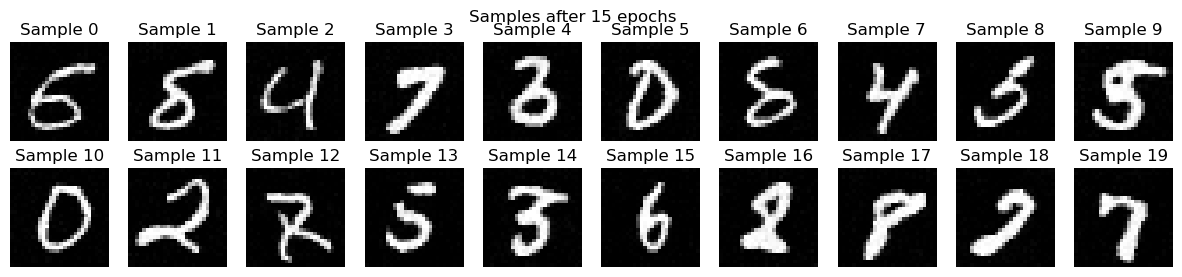

Epoch [15/20], Loss: 0.0147
Epoch [16/20], Batch [1/469], Loss: 0.0170
Epoch [16/20], Batch [101/469], Loss: 0.0167
Epoch [16/20], Batch [201/469], Loss: 0.0172
Epoch [16/20], Batch [301/469], Loss: 0.0152
Epoch [16/20], Batch [401/469], Loss: 0.0186
Epoch [16/20], Loss: 0.0123
Epoch [17/20], Batch [1/469], Loss: 0.0149
Epoch [17/20], Batch [101/469], Loss: 0.0196
Epoch [17/20], Batch [201/469], Loss: 0.0156
Epoch [17/20], Batch [301/469], Loss: 0.0147
Epoch [17/20], Batch [401/469], Loss: 0.0141
Epoch [17/20], Loss: 0.0189
Epoch [18/20], Batch [1/469], Loss: 0.0158
Epoch [18/20], Batch [101/469], Loss: 0.0158
Epoch [18/20], Batch [201/469], Loss: 0.0141
Epoch [18/20], Batch [301/469], Loss: 0.0158
Epoch [18/20], Batch [401/469], Loss: 0.0194
Epoch [18/20], Loss: 0.0214
Epoch [19/20], Batch [1/469], Loss: 0.0194
Epoch [19/20], Batch [101/469], Loss: 0.0176
Epoch [19/20], Batch [201/469], Loss: 0.0188
Epoch [19/20], Batch [301/469], Loss: 0.0141
Epoch [19/20], Batch [401/469], Loss: 0.0

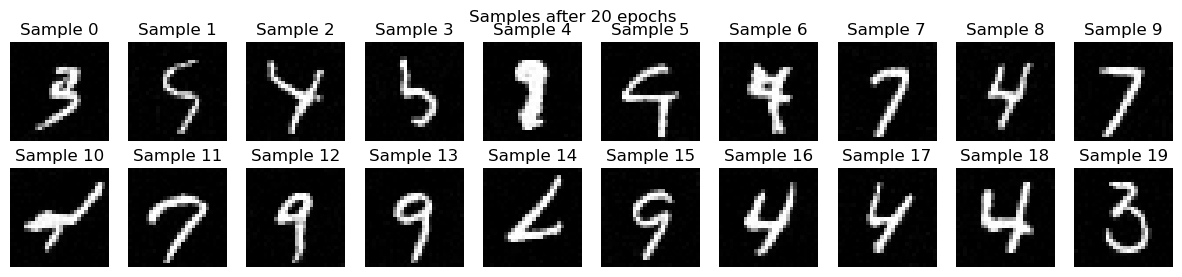

Epoch [20/20], Loss: 0.0146


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

dataset = MNIST(root='data', download=True, transform=ToTensor(), train=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# TODO
batch_size = 128
epochs = 20
D = 64
lr = 1e-3

model = TimeConditionalUNet(in_channels=1, num_classes=1, num_hiddens=D).to(device)
ddpm = DDPM(model, num_ts=1000).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []
step = []

for epoch in range(epochs):
    model.train()
    for i, (images, _) in enumerate(dataloader):
        images = images.to(device)
        optimizer.zero_grad()
        loss = ddpm(images)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        step.append(epoch * len(dataloader) + i)
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

    if epoch in [0, 4, 9, 14, 19]:
        model.eval()
        sampled_images = ddpm.sample(img_wh=(28, 28), seed=epoch)
        sampled_images = sampled_images.detach().cpu()

        fig, axes = plt.subplots(2, 10, figsize=(15, 3))
        for i in range(20):
            row = i//10
            col = i % 10
            axes[row,col].imshow(sampled_images[i, 0], cmap='gray')
            axes[row,col].axis("off")
            axes[row,col].set_title(f'Sample {i}')
        plt.suptitle(f'Samples after {epoch + 1} epochs')
        plt.show()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")



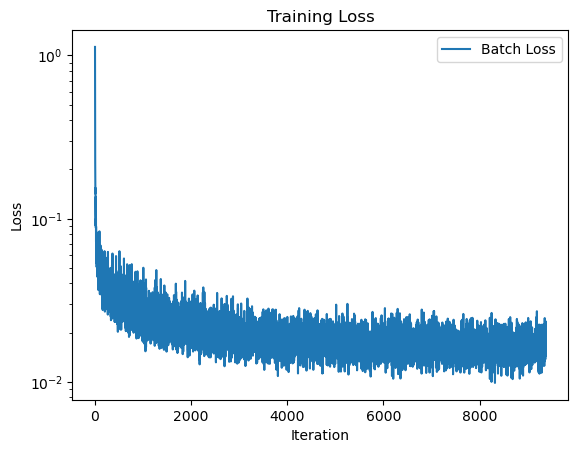

In [18]:
plt.plot(losses, label='Batch Loss')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.yscale('log')

plt.legend()
plt.show()

### Implementing class-conditioned UNet

In [21]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.num_classes = num_classes
        self.num_hiddens = num_hiddens
        self.convblock1 = ConvBlock(in_channels, num_hiddens)
        self.downblock1 = DownBlock(num_hiddens, num_hiddens)
        self.downblock2 = DownBlock(num_hiddens, num_hiddens * 2)
        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2)
        self.upblock1 = UpBlock(num_hiddens * 4, num_hiddens)
        self.upblock2 = UpBlock(num_hiddens * 2, num_hiddens)
        self.convblock2 = ConvBlock(num_hiddens * 2, num_hiddens)
        self.conv2d = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, stride=1, padding=1)
        self.fc1_t = FCBlock(1, num_hiddens * 2)
        self.fc1_c = FCBlock(num_classes, 2 * num_hiddens)
        self.fc2_t = FCBlock(1, num_hiddens)
        self.fc2_c = FCBlock(num_classes, num_hiddens)

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        one_hot_c = nn.functional.one_hot(c, num_classes=self.num_classes).float()
        x1 = self.convblock1(x)
        x2 = self.downblock1(x1)
        x3 = self.downblock2(x2)
        x4 = self.flatten(x3)
        unflattened = self.unflatten(x4)
        condition = self.fc1_c(one_hot_c)
        condition = condition.view(condition.shape[0], condition.shape[1], 1, 1)
        x5 = unflattened * condition + self.fc1_t(t).view(-1, self.num_hiddens * 2, 1, 1)
        x7 = torch.cat([x3, x5], dim=1)
        condition2 = self.fc2_c(one_hot_c)
        condition2 = condition2.view(condition2.shape[0], condition2.shape[1], 1, 1)
        x8 = self.upblock1(x7) * condition2 + self.fc2_t(t).view(-1, self.num_hiddens, 1, 1)
        x10 = torch.cat([x2, x8], dim=1)
        x11 = self.upblock2(x10)
        x12 = torch.cat([x1, x11], dim=1)
        x13 = self.convblock2(x12)
        x14 = self.conv2d(x13)
        return x14

In [22]:
def ddpm_forward(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        (,) diffusion loss.
    """
    unet.train()
    # YOUR CODE HERE.
    batch_size = x_0.shape[0]
    t = torch.randint(0, num_ts, (batch_size,), device=x_0.device)
    mask = torch.rand(x_0.shape[0], device=x_0.device) >= p_uncond
    noise = torch.randn_like(x_0)
    alpha_bar_t = ddpm_schedule['alpha_bars'][t.long()].view(-1, 1, 1, 1)
    x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise
    t_normalized = t.float() / num_ts
    predicted_noise = unet(x_t, c, t_normalized.view(-1, 1), mask.view(-1, 1))
    loss = nn.functional.mse_loss(predicted_noise, noise)
    return loss

In [23]:
@torch.inference_mode()
def ddpm_sample(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        c: (N,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
        (N, T_animation, C, H, W) caches.
    """
    unet.eval()
    # YOUR CODE HERE.
    batch_size = 20
    x_t = torch.randn((batch_size, 1, *img_wh), device=ddpm_schedule['alphas'].device)
    for t in reversed(range(num_ts)):
        t_tensor = torch.full((x_t.shape[0],), t / num_ts, device=x_t.device).float().view(-1, 1)
        eps_u = unet(x_t, c, t_tensor, torch.zeros_like(c))
        eps_c = unet(x_t, c, t_tensor, torch.ones_like(c))
        eps = eps_u + guidance_scale * (eps_c - eps_u)

        alpha_t = ddpm_schedule['alphas'][t].view(-1, 1, 1, 1)
        alpha_bar_t = ddpm_schedule['alpha_bars'][t].view(-1, 1, 1, 1)
        beta_t = ddpm_schedule['betas'][t].view(-1, 1, 1, 1)

        z = torch.randn_like(x_t) if t > 0 else torch.zeros_like(x_t)
        x_t = (1 / torch.sqrt(alpha_t)) * (x_t - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * eps) + (torch.sqrt(beta_t) * z)
    return torch.clamp(x_t, 0, 1)

In [24]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = nn.ParameterDict(ddpm_schedule(betas[0], betas[1], num_ts))

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, c, img_wh, self.num_ts, guidance_scale, seed
        )

## Training the Class-conditioned UNet

- Plot the loss curve
- Sample results on the test set

cuda
Epoch [1/20], Batch [1/469], Loss: 1.0675
Epoch [1/20], Batch [101/469], Loss: 0.0408
Epoch [1/20], Batch [201/469], Loss: 0.0414
Epoch [1/20], Batch [301/469], Loss: 0.0301
Epoch [1/20], Batch [401/469], Loss: 0.0257


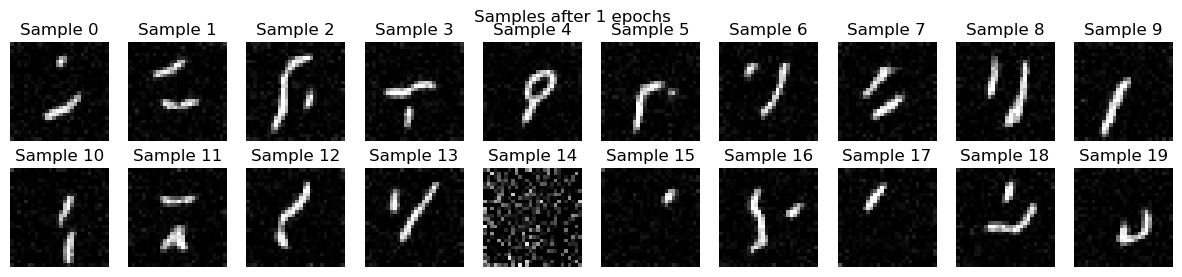

Epoch [1/20], Loss: 0.0248
Epoch [2/20], Batch [1/469], Loss: 0.0292
Epoch [2/20], Batch [101/469], Loss: 0.0358
Epoch [2/20], Batch [201/469], Loss: 0.0218
Epoch [2/20], Batch [301/469], Loss: 0.0313
Epoch [2/20], Batch [401/469], Loss: 0.0280
Epoch [2/20], Loss: 0.0239
Epoch [3/20], Batch [1/469], Loss: 0.0259
Epoch [3/20], Batch [101/469], Loss: 0.0323
Epoch [3/20], Batch [201/469], Loss: 0.0429
Epoch [3/20], Batch [301/469], Loss: 0.0219
Epoch [3/20], Batch [401/469], Loss: 0.0187
Epoch [3/20], Loss: 0.0352
Epoch [4/20], Batch [1/469], Loss: 0.0215
Epoch [4/20], Batch [101/469], Loss: 0.0285
Epoch [4/20], Batch [201/469], Loss: 0.0235
Epoch [4/20], Batch [301/469], Loss: 0.0250
Epoch [4/20], Batch [401/469], Loss: 0.0248
Epoch [4/20], Loss: 0.0307
Epoch [5/20], Batch [1/469], Loss: 0.0199
Epoch [5/20], Batch [101/469], Loss: 0.0245
Epoch [5/20], Batch [201/469], Loss: 0.0226
Epoch [5/20], Batch [301/469], Loss: 0.0225
Epoch [5/20], Batch [401/469], Loss: 0.0274


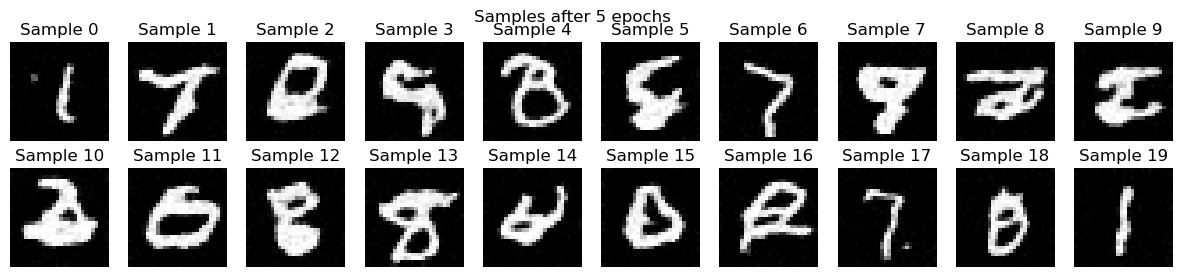

Epoch [5/20], Loss: 0.0265
Epoch [6/20], Batch [1/469], Loss: 0.0195
Epoch [6/20], Batch [101/469], Loss: 0.0187
Epoch [6/20], Batch [201/469], Loss: 0.0209
Epoch [6/20], Batch [301/469], Loss: 0.0208
Epoch [6/20], Batch [401/469], Loss: 0.0181
Epoch [6/20], Loss: 0.0166
Epoch [7/20], Batch [1/469], Loss: 0.0172
Epoch [7/20], Batch [101/469], Loss: 0.0141
Epoch [7/20], Batch [201/469], Loss: 0.0142
Epoch [7/20], Batch [301/469], Loss: 0.0209
Epoch [7/20], Batch [401/469], Loss: 0.0194
Epoch [7/20], Loss: 0.0169
Epoch [8/20], Batch [1/469], Loss: 0.0182
Epoch [8/20], Batch [101/469], Loss: 0.0200
Epoch [8/20], Batch [201/469], Loss: 0.0195
Epoch [8/20], Batch [301/469], Loss: 0.0182
Epoch [8/20], Batch [401/469], Loss: 0.0229
Epoch [8/20], Loss: 0.0164
Epoch [9/20], Batch [1/469], Loss: 0.0196
Epoch [9/20], Batch [101/469], Loss: 0.0192
Epoch [9/20], Batch [201/469], Loss: 0.0170
Epoch [9/20], Batch [301/469], Loss: 0.0187
Epoch [9/20], Batch [401/469], Loss: 0.0209
Epoch [9/20], Loss: 

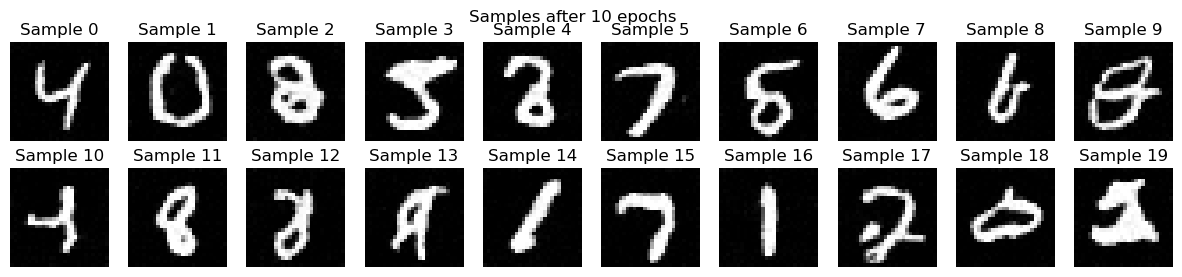

Epoch [10/20], Loss: 0.0252
Epoch [11/20], Batch [1/469], Loss: 0.0156
Epoch [11/20], Batch [101/469], Loss: 0.0207
Epoch [11/20], Batch [201/469], Loss: 0.0234
Epoch [11/20], Batch [301/469], Loss: 0.0205
Epoch [11/20], Batch [401/469], Loss: 0.0187
Epoch [11/20], Loss: 0.0141
Epoch [12/20], Batch [1/469], Loss: 0.0272
Epoch [12/20], Batch [101/469], Loss: 0.0137
Epoch [12/20], Batch [201/469], Loss: 0.0211
Epoch [12/20], Batch [301/469], Loss: 0.0201
Epoch [12/20], Batch [401/469], Loss: 0.0127
Epoch [12/20], Loss: 0.0280
Epoch [13/20], Batch [1/469], Loss: 0.0151
Epoch [13/20], Batch [101/469], Loss: 0.0141
Epoch [13/20], Batch [201/469], Loss: 0.0160
Epoch [13/20], Batch [301/469], Loss: 0.0240
Epoch [13/20], Batch [401/469], Loss: 0.0137
Epoch [13/20], Loss: 0.0130
Epoch [14/20], Batch [1/469], Loss: 0.0155
Epoch [14/20], Batch [101/469], Loss: 0.0178
Epoch [14/20], Batch [201/469], Loss: 0.0141
Epoch [14/20], Batch [301/469], Loss: 0.0158
Epoch [14/20], Batch [401/469], Loss: 0.0

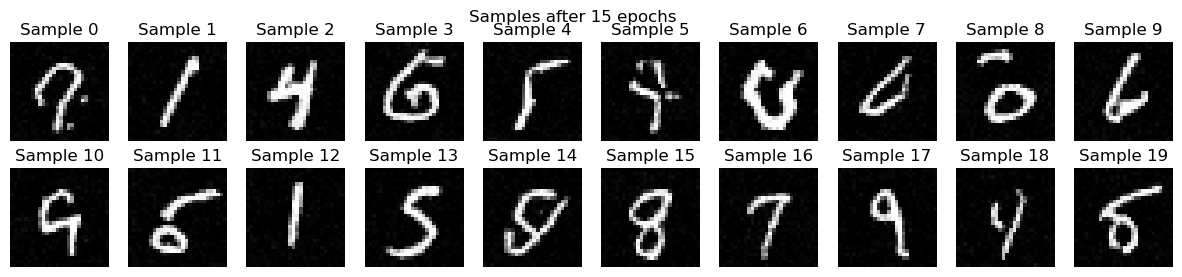

Epoch [15/20], Loss: 0.0147
Epoch [16/20], Batch [1/469], Loss: 0.0201
Epoch [16/20], Batch [101/469], Loss: 0.0166
Epoch [16/20], Batch [201/469], Loss: 0.0187
Epoch [16/20], Batch [301/469], Loss: 0.0156
Epoch [16/20], Batch [401/469], Loss: 0.0126
Epoch [16/20], Loss: 0.0227
Epoch [17/20], Batch [1/469], Loss: 0.0210
Epoch [17/20], Batch [101/469], Loss: 0.0270
Epoch [17/20], Batch [201/469], Loss: 0.0115
Epoch [17/20], Batch [301/469], Loss: 0.0183
Epoch [17/20], Batch [401/469], Loss: 0.0161
Epoch [17/20], Loss: 0.0176
Epoch [18/20], Batch [1/469], Loss: 0.0187
Epoch [18/20], Batch [101/469], Loss: 0.0212
Epoch [18/20], Batch [201/469], Loss: 0.0203
Epoch [18/20], Batch [301/469], Loss: 0.0097
Epoch [18/20], Batch [401/469], Loss: 0.0125
Epoch [18/20], Loss: 0.0195
Epoch [19/20], Batch [1/469], Loss: 0.0124
Epoch [19/20], Batch [101/469], Loss: 0.0158
Epoch [19/20], Batch [201/469], Loss: 0.0188
Epoch [19/20], Batch [301/469], Loss: 0.0178
Epoch [19/20], Batch [401/469], Loss: 0.0

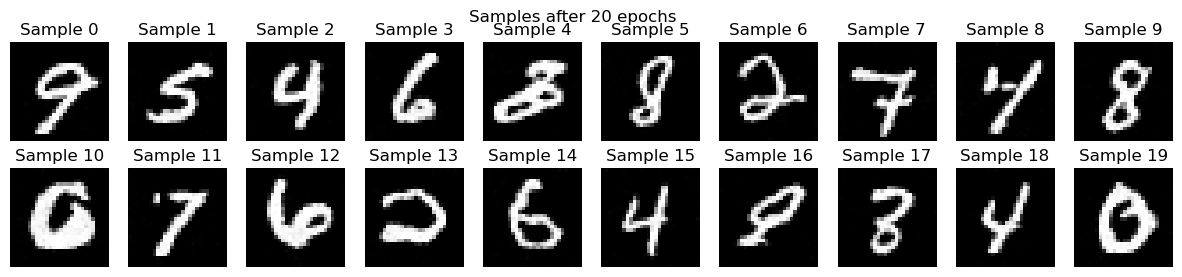

Epoch [20/20], Loss: 0.0170


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

dataset = MNIST(root='data', download=True, transform=ToTensor(), train=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

batch_size = 128
epochs = 20
D = 64
lr = 1e-3
p_uncond = 0.1

model = ClassConditionalUNet(in_channels=1, num_classes=10, num_hiddens=D).to(device)
ddpm = DDPM(model, num_ts=1000, p_uncond=p_uncond).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []
step = []

# TODO
for epoch in range(epochs):
    model.train()
    for i, (images, _) in enumerate(dataloader):
        images = images.to(device)
        optimizer.zero_grad()
        c = torch.randint(0, 10, (images.shape[0],), device=images.device)
        loss = ddpm(images, c)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        step.append(epoch * len(dataloader) + i)
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

    if epoch in [0, 4, 9, 14, 19]:
        model.eval()
        c = torch.randint(0, 10, (20,), device=device)
        sampled_images = ddpm.sample(c=c, img_wh=(28, 28), seed=epoch)
        sampled_images = sampled_images.detach().cpu()

        
        fig, axes = plt.subplots(2, 10, figsize=(15, 3))
        for i in range(20):
            row = i//10
            col = i % 10
            axes[row,col].imshow(sampled_images[i, 0], cmap='gray')
            axes[row,col].axis("off")
            axes[row,col].set_title(f'Sample {i}')
        plt.suptitle(f'Samples after {epoch + 1} epochs')
        plt.show()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

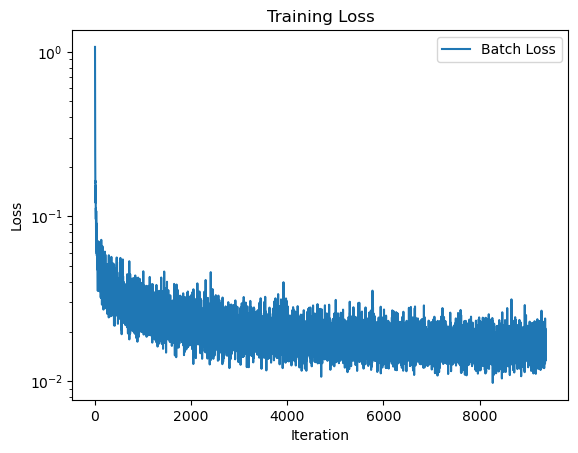

In [26]:
plt.plot(losses, label='Batch Loss')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.yscale('log')

plt.legend()
plt.show()